In [1]:
from matplotlib.pyplot import subplots, style, rc
from urllib.parse import quote
from pandas import read_csv
from numpy import log
from seaborn import clustermap

In [2]:
style.use(["seaborn-whitegrid", "seaborn-poster"])
rc("axes", linewidth=1, edgecolor="black")
%matplotlib inline

In [3]:
API_ROOT = "https://visualization.genelab.nasa.gov/GLOpenAPI"

#### Disclaimer

**This example does not intend to provide any scientific interpretation of the data** – here we purely demonstrate how to *obtain* such data from the API and how to work with it in Python. As such, this notebook does not operate on any scientific hypotheses and employs a painfully simplistic and naive approach for the sake of brevity.  
The methods in this notebook are not verified by, endorsed by, or representative of, actual NASA GeneLab best practices and data processing pipelines.

#### Introduction

The NASA GeneLab Open API follows the [ISA-Tab](https://isa-specs.readthedocs.io/en/latest/) spec and organizes metadata according to the fields supplied by the researchers in ISA ZIP files associated with each dataset.  
See the "Structure" section on the [API landing page](https://visualization.genelab.nasa.gov/GLOpenAPI/) for more information.

Most often, ISA fields under "study.characteristics" and "study.factor value" are of interest, as well as the additional fields "file.filename" and "file.datatype". The easiest way to obtain an overview of these values is to add any of them to the "samples" query, for example:  
https://visualization.genelab.nasa.gov/GLOpenAPI/samples/?study.characteristics&format=browser  

Note: most of the cell values will be NaN, owing to the fact that the output table is merged from a big number of studies that track different characteristics. The "browser" format allows for sorting the columns by clicking on their subheaders – you may double-click each subheader to bring non-NaN values to the top of the table.

#### Deciding on fields of interest

Let's say we are interested in all *Mus musculus* samples that have a **characteristic** of "material type" and **factor values** of "spaceflight" and "dissection condition".  
Furthermore, as we want to work with RNA-Seq data, we only care about the datasets/samples/assays that have files of
**datatype** of "unnormalized counts".

<font style=font-size:smaller>(Alternatively, we could subset to RNA-Seq data by requesting only the samples whose **study assay technology type** is that of "RNA Sequencing (RNA-Seq)" by appending `investigation.study assays.study assay technology type=RNA Sequencing (RNA-Seq)`, but we'd still need the **datatype** constraint – otherwise the API would also return other files, such as fastqs, plots, and so on).</font>

The query itself, therefore, is simply a string of these requests, joined by ampersands.  
One important note here is that because some field names and values may contain special characters, such as spaces, they need to be percent-encoded with `urllib.parse.quote()`:

In [4]:
query = "&".join((
    "study.characteristics.organism="+quote("Mus musculus"),
    quote("study.characteristics.material type"),
    quote("study.factor value.spaceflight"),
    quote("study.factor value.dissection condition"),
    "file.datatype="+quote("unnormalized counts"),
))
query

'study.characteristics.organism=Mus%20musculus&study.characteristics.material%20type&study.factor%20value.spaceflight&study.factor%20value.dissection%20condition&file.datatype=unnormalized%20counts'

#### Requesting the annotation dataframe

Annotation dataframes can be obtained by appending this query to the "/samples/" endpoint – because we are requesting per-sample information. The default output format is CSV.

Note that output **annotation** tables, as described in the "Display formats" section on the [API landing page](https://visualization.genelab.nasa.gov/GLOpenAPI/), have *two* levels of column names, and these levels are prefixed with the pound symbol ('#'), therefore we need to inform pandas about it.  
You may also want to treat the first three columns (the "id" columns) as the dataframe's index.

In [5]:
annotation_url = f"{API_ROOT}/samples/?{query}"
annotation_url

'https://visualization.genelab.nasa.gov/GLOpenAPI/samples/?study.characteristics.organism=Mus%20musculus&study.characteristics.material%20type&study.factor%20value.spaceflight&study.factor%20value.dissection%20condition&file.datatype=unnormalized%20counts'

In [6]:
annotation = read_csv(annotation_url, header=[0, 1], escapechar="#")
annotation = annotation.set_index(annotation.columns[:3].tolist())
annotation

study.characteristics  \
                                                                                                             material type   
(id, accession) (id, assay name)                                   (id, sample name)                                         
GLDS-244        rr6_tms_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_TMS_BSL_ISS-T_Rep1_B1                Thymus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep2_B2                Thymus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep3_B3                Thymus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep4_B4                Thymus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep5_B5                Thymus   
...                                                                                                                    ...   
GLDS-248        rr6_lng_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_LNG_GC_LAR_Rep5_G6           left lung lobe   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep6_G7           left lung lobe   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep7_G8           left lung lobe   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep8_G9           left lung lobe   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep9_G10          left lung lobe   

                                                                                                                    \
                                                                                                          organism   
(id, accession) (id, assay name)                                   (id, sample name)                                 
GLDS-244        rr6_tms_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_TMS_BSL_ISS-T_Rep1_B1  Mus musculus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep2_B2  Mus musculus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep3_B3  Mus musculus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep4_B4  Mus musculus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep5_B5  Mus musculus   
...                                                                                                            ...   
GLDS-248        rr6_lng_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_LNG_GC_LAR_Rep5_G6     Mus musculus   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep6_G7     Mus musculus   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep7_G8     Mus musculus   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep8_G9     Mus musculus   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep9_G10    Mus musculus   

                                                                                                       study.factor value  \
                                                                                                     dissection condition   
(id, accession) (id, assay name)                                   (id, sample name)                                        
GLDS-244        rr6_tms_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_TMS_BSL_ISS-T_Rep1_B1              Carcass   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep2_B2              Carcass   
                                                          

#### Requesting the unnormalized counts dataframe

Data dataframes can be obtained by appending this query to the "/data/" endpoint.  The default output format is CSV.  
Because the query contains the constraint `file.datatype=unnormalized counts`, the API will merge the colums only from such files.

Note that **data** output tables, as described in the "Display formats" section on the [API landing page](https://visualization.genelab.nasa.gov/GLOpenAPI/), have *three* levels of column names, and these levels are prefixed with the pound symbol ('#'), therefore we need to inform pandas about it.  
Also, you may want to treat the leftmost column (gene names) as an index.

<font style="font-size: smaller; display: inline-block; border: 1px solid red; padding: 5pt;">Note that the table in this example is rather large: 55628 rows by 218 columns; it may take several minutes for `pandas.read_csv()` to process this.  
In addition to resources required on the user's machine, there is another consequence to this: **if** such a query is requested from the server for the first time *ever* (i.e., no other user has ever requested this URL before), it will take the *server* some time to prepare the table, and you may run into a Gateway Timeout error.  
However, this will still trigger the relevant process on the server, and the output will become available after a few minutes, after which, the subsequent requests for this query will return almost instantaneously; the only delays at this point will be due to `pandas.read_csv()` processing the incoming data.</font>

In [7]:
data_url = f"{API_ROOT}/data/?{query}"
data_url

'https://visualization.genelab.nasa.gov/GLOpenAPI/data/?study.characteristics.organism=Mus%20musculus&study.characteristics.material%20type&study.factor%20value.spaceflight&study.factor%20value.dissection%20condition&file.datatype=unnormalized%20counts'

In [8]:
data = read_csv(data_url, header=[0, 1, 2], escapechar="#", index_col=0)
data

*                                                                  GLDS-244  \
*                  rr6_tms_transcription_profiling_RNA_Sequencing_(RNA-Seq)   
index                                   Mmus_C57-6T_TMS_FLT_ISS-T_Rep10_F10   
ENSMUSG00000000001                                               25.0         
ENSMUSG00000000003                                                0.0         
ENSMUSG00000000028                                                6.0         
ENSMUSG00000000031                                                3.0         
ENSMUSG00000000037                                                1.0         
...                                                               ...         
ERCC-00164                                                        0.0         
ERCC-00165                                                        0.0         
ERCC-00168                                                        0.0         
ERCC-00170                                                        1.0         
ERCC-00171                                                       75.0         

*                                                   \
*                                                    
index              Mmus_C57-6T_TMS_FLT_LAR_Rep2_F2   
ENSMUSG00000000001                            46.0   
ENSMUSG00000000003                             0.0   
ENSMUSG00000000028                             1.0   
ENSMUSG00000000031                             9.0   
ENSMUSG00000000037                             1.0   
...                                            ...   
ERCC-00164                                     0.0   
ERCC-00165                                    11.0   
ERCC-00168                                     0.0   
ERCC-00170                                     0.0   
ERCC-00171                                   315.0   

*                                                   \
*                                                    
index              Mmus_C57-6T_TMS_FLT_LAR_Rep3_F4   
ENSMUSG00000000001                            54.0   
ENSMUSG00000000003                             0.0   
ENSMUSG00000000028                             5.0   
ENSMUSG00000000031                           388.0   
ENSMUSG00000000037                             1.0   
...                                            ...   
ERCC-00164                                     0.0   
ERCC-00165                                     5.0   
ERCC-00168                                     0.0   
ERCC-00170                                     0.0   
ERCC-00171                                   289.0   

*                                                   \
*                                                    
index              Mmus_C57-6T_TMS_FLT_LAR_Rep4_F5   
ENSMUSG00000000001                            33.0   
ENSMUSG00000000003                             0.0   
ENSMUSG00000000028                             1.0   
ENSMUSG00000000031                             1.0   
ENSMUSG00000000037                             1.0   
...                                            ...   
ERCC-00164                                     0.0   
ERCC-00165                                    11.0   
ERCC-00168                                     0.0   
ERCC-00170                                     0.0   
ERCC-00171                                   177.0   

*                                                   \
*                                                    
index              Mmus_C57-6T_TMS_FLT_LAR_Rep5_F6   
ENSMUSG00000000001                           104.0   
ENSMUSG00000000003                             0.0   
ENSMUSG00000000028                            18.0   
ENSMUSG00000000031                             1.0   
ENSMUSG00000000037                             3.0   
...                                            ...   
ERCC-00164                                     0.0   
ERCC-00165                                     9.0   
ERCC-00168                  

#### Normalizing the data

Let's perform some data normalization: normalize by library size, perform a log-transform, and then z-score the rows.

In [9]:
loglibnorm_data = log(1e-6 + data / data.mean())
z_mean = loglibnorm_data.mean(axis=1)
z_std = loglibnorm_data.std(axis=1)
z_data = loglibnorm_data.sub(z_mean, axis=0).div(z_std, axis=0)
z_data

*                                                                  GLDS-244  \
*                  rr6_tms_transcription_profiling_RNA_Sequencing_(RNA-Seq)   
index                                   Mmus_C57-6T_TMS_FLT_ISS-T_Rep10_F10   
ENSMUSG00000000001                                           0.377929         
ENSMUSG00000000003                                          -0.136366         
ENSMUSG00000000028                                           0.955633         
ENSMUSG00000000031                                           0.932703         
ENSMUSG00000000037                                           1.635723         
...                                                               ...         
ERCC-00164                                                  -0.117748         
ERCC-00165                                                  -1.439551         
ERCC-00168                                                  -0.095768         
ERCC-00170                                                   0.771252         
ERCC-00171                                                  -0.034471         

*                                                   \
*                                                    
index              Mmus_C57-6T_TMS_FLT_LAR_Rep2_F2   
ENSMUSG00000000001                        0.520231   
ENSMUSG00000000003                       -0.136366   
ENSMUSG00000000028                        0.590338   
ENSMUSG00000000031                        1.066506   
ENSMUSG00000000037                        1.574324   
...                                            ...   
ERCC-00164                               -0.117748   
ERCC-00165                                0.884322   
ERCC-00168                               -0.095768   
ERCC-00170                               -1.119544   
ERCC-00171                                1.219666   

*                                                   \
*                                                    
index              Mmus_C57-6T_TMS_FLT_LAR_Rep3_F4   
ENSMUSG00000000001                        0.604771   
ENSMUSG00000000003                       -0.136366   
ENSMUSG00000000028                        0.877389   
ENSMUSG00000000031                        1.695788   
ENSMUSG00000000037                        1.580257   
...                                            ...   
ERCC-00164                               -0.117748   
ERCC-00165                                0.744621   
ERCC-00168                               -0.095768   
ERCC-00170                               -1.119544   
ERCC-00171                                1.156124   

*                                                   \
*                                                    
index              Mmus_C57-6T_TMS_FLT_LAR_Rep4_F5   
ENSMUSG00000000001                        0.364219   
ENSMUSG00000000003                       -0.136366   
ENSMUSG00000000028                        0.587552   
ENSMUSG00000000031                        0.699246   
ENSMUSG00000000037                        1.570985   
...                                            ...   
ERCC-00164                               -0.117748   
ERCC-00165                                0.881401   
ERCC-00168                               -0.095768   
ERCC-00170                               -1.119544   
ERCC-00171                                0.569621   

*                                                   \
*                                                    
index              Mmus_C57-6T_TMS_FLT_LAR_Rep5_F6   
ENSMUSG00000000001                        0.859257   
ENSMUSG00000000003                       -0.136366   
ENSMUSG00000000028                        1.086538   
ENSMUSG00000000031                        0.692017   
ENSMUSG00000000037                        1.792589   
...                                            ...   
ERCC-00164                               -0.117748   
ERCC-00165                                0.836519   
ERCC-00168                  

#### Clustering the data

Let's first simplify our annotation table to only include the columns we are interested in now: we might not need the qualifiers "study.characteristics" and "study.factor value" at this point, nor will we need the "file" columns, and since "organism" is always "Mus musculus", we can dispense with it, too:

In [10]:
ANNOT_COLS = ["study.characteristics", "study.factor value"]
visual_annotation = annotation[ANNOT_COLS].droplevel(0, axis="columns").drop(columns="organism")
visual_annotation

material type  \
(id, accession) (id, assay name)                                   (id, sample name)                                   
GLDS-244        rr6_tms_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_TMS_BSL_ISS-T_Rep1_B1          Thymus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep2_B2          Thymus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep3_B3          Thymus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep4_B4          Thymus   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep5_B5          Thymus   
...                                                                                                              ...   
GLDS-248        rr6_lng_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_LNG_GC_LAR_Rep5_G6     left lung lobe   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep6_G7     left lung lobe   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep7_G8     left lung lobe   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep8_G9     left lung lobe   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep9_G10    left lung lobe   

                                                                                                     dissection condition  \
(id, accession) (id, assay name)                                   (id, sample name)                                        
GLDS-244        rr6_tms_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_TMS_BSL_ISS-T_Rep1_B1              Carcass   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep2_B2              Carcass   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep3_B3              Carcass   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep4_B4              Carcass   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep5_B5              Carcass   
...                                                                                                                   ...   
GLDS-248        rr6_lng_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_LNG_GC_LAR_Rep5_G6         Upon euthanasia   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep6_G7         Upon euthanasia   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep7_G8         Upon euthanasia   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep8_G9         Upon euthanasia   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep9_G10        Upon euthanasia   

                                                                                                         spaceflight  
(id, accession) (id, assay name)                                   (id, sample name)                                  
GLDS-244        rr6_tms_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_TMS_BSL_ISS-T_Rep1_B1   Basal Control  
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep2_B2   Basal Control  
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep3_B3   Basal Control  
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep4_B4   Basal Control  
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep5_B5   Basal Control  
...                                                                                

Now, let's assign some colors to each of the values in the annotation:

In [11]:
col_colors = visual_annotation.applymap({
    "Thymus": "orange",
    "left lung lobe": "skyblue",
    "liver": "brown",
    "spleen": "lightgreen",
    "Carcass": "yellow",
    "Upon euthanasia": "red",
    "Basal Control": "lightgray",
    "Ground Control": "#00CC77",
    "Space Flight": "#0077FF",
}.get)

col_colors

material type  \
(id, accession) (id, assay name)                                   (id, sample name)                                 
GLDS-244        rr6_tms_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_TMS_BSL_ISS-T_Rep1_B1        orange   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep2_B2        orange   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep3_B3        orange   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep4_B4        orange   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep5_B5        orange   
...                                                                                                            ...   
GLDS-248        rr6_lng_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_LNG_GC_LAR_Rep5_G6          skyblue   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep6_G7          skyblue   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep7_G8          skyblue   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep8_G9          skyblue   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep9_G10         skyblue   

                                                                                                     dissection condition  \
(id, accession) (id, assay name)                                   (id, sample name)                                        
GLDS-244        rr6_tms_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_TMS_BSL_ISS-T_Rep1_B1               yellow   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep2_B2               yellow   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep3_B3               yellow   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep4_B4               yellow   
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep5_B5               yellow   
...                                                                                                                   ...   
GLDS-248        rr6_lng_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_LNG_GC_LAR_Rep5_G6                     red   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep6_G7                     red   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep7_G8                     red   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep8_G9                     red   
                                                                   Mmus_C57-6T_LNG_GC_LAR_Rep9_G10                    red   

                                                                                                     spaceflight  
(id, accession) (id, assay name)                                   (id, sample name)                              
GLDS-244        rr6_tms_transcription_profiling_RNA_Sequencing_... Mmus_C57-6T_TMS_BSL_ISS-T_Rep1_B1   lightgray  
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep2_B2   lightgray  
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep3_B3   lightgray  
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep4_B4   lightgray  
                                                                   Mmus_C57-6T_TMS_BSL_ISS-T_Rep5_B5   lightgray  
...                                                                                                          ...  
GLDS-248        rr6_

Finally, let us cluster the data.  
While `seaborn` automatically assigns the correct annotation to each column based on the columns' names and the names of the `col_colors` indices, here we pedantically rearrange `z_data` according to the annotation index – this is absolutely not required.

Again, because the dataframe is fairly large, this step may take quite some time. To speed this up, you may want to filter down `z_data` based on your preferred criteria – median values, variation, etc.

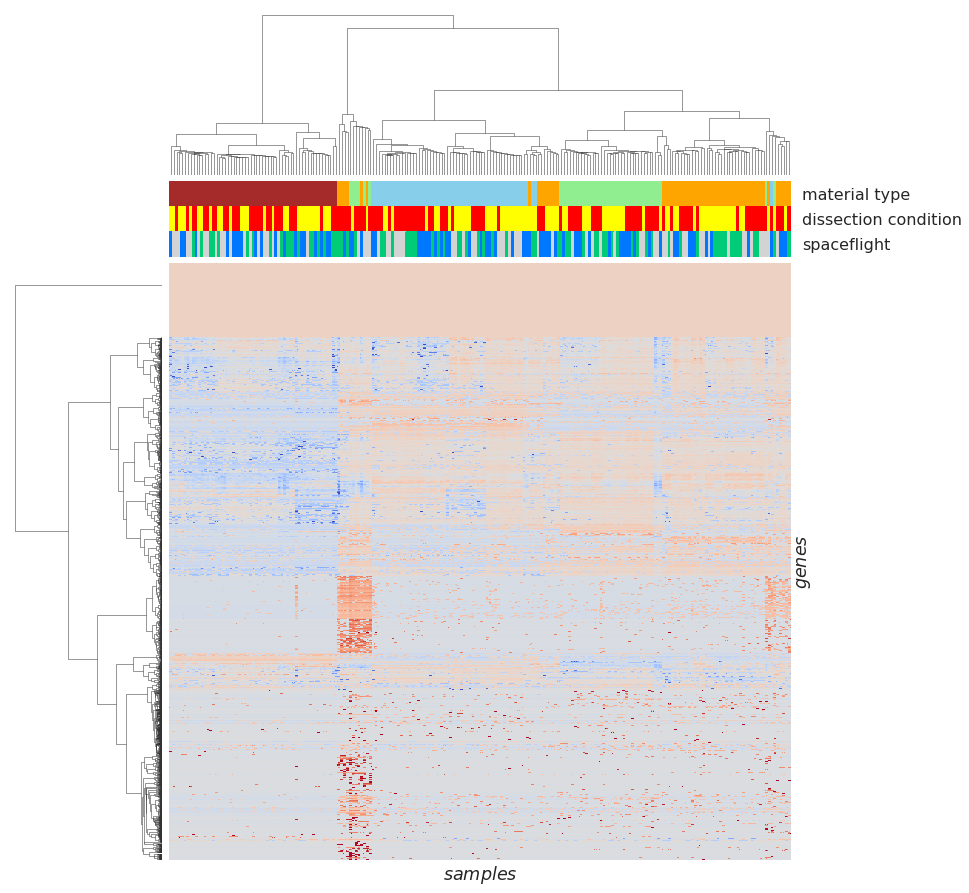

In [12]:
cg = clustermap(
    z_data[col_colors.index], metric="euclidean", method="ward",
    col_colors=col_colors, cmap="coolwarm", vmin=-7, vmax=7,
    figsize=(14, 25),
)

cg.ax_heatmap.set(xlabel="$samples$", xticks=[], ylabel="$genes$", yticks=[])
_ = cg.cax.set(visible=False)

#### Closing thoughts

Note that this example does not intend to provide any scientific interpretation of the data – here we purely demonstrate how to *obtain* such data from the API and how to work with it in Python.  
For example, we did not consider batch correction at all, may have strayed away from the best practices for data normalization, etc, etc.

As per the disclaimer above, the methods in this notebook are not verified by, endorsed by, or representative of, actual NASA GeneLab best practices and data processing pipelines.

However, a couple of things immediately catch one's attention. First, the samples quite expectedly cluster by material type (for the most part), which should of course be considered when running actual analyses. Second, there is a number of samples that has a very different expression profile from the rest, which does not appear to be driven by either factor or characteristic; it is possible that other factors are at play here – after all, we only included a few in the annotation for the sake of brevity; there is a plethora of other information to consider, such as rRNA contamination, types of sequencers, variation in sample preparation, and so on.